<a href="https://colab.research.google.com/github/pranshurastogi29/how-effective-are-std-drugs/blob/master/STD_AI_pipeline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from __future__ import absolute_import, division
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
files.upload()
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d takuok/glove840b300dtxt
!kaggle datasets download -d yekenot/fasttext-crawl-300d-2m
!unzip glove840b300dtxt.zip
!unzip fasttext-crawl-300d-2m.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Apr 25 11:01 kaggle.json
100% 2.08G/2.08G [00:22<00:00, 38.3MB/s]
100% 2.08G/2.08G [00:22<00:00, 97.7MB/s]
100% 1.44G/1.44G [00:38<00:00, 39.8MB/s]
100% 1.44G/1.44G [00:38<00:00, 40.2MB/s]
Archive:  glove840b300dtxt.zip
  inflating: glove.840B.300d.txt     
Archive:  fasttext-crawl-300d-2m.zip
  inflating: crawl-300d-2M.vec       


In [2]:
import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [3]:
import os
import gc
import joblib
import re
import time
import psutil
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from sklearn.model_selection import KFold
from multiprocessing import Pool
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from scipy import stats
from scipy.stats import norm,skew
from sklearn.preprocessing import *
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers import *
from keras.models import Model, load_model
from keras.engine import InputSpec, Layer
from keras.callbacks import *
from keras.optimizers import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
df = pd.read_csv('/content/drive/My Drive/train.csv')
df = df.drop(columns=['drug_approved_by_UIC','patient_id'])
df1 = pd.read_csv('/content/drive/My Drive/test.csv')
df.head()

,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,number_of_times_prescribed,base_score
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,27,8.022969
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,192,7.858458
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,17,6.341969
3,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,37,6.590176
4,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,43,6.144782


In [5]:
df.describe()

,effectiveness_rating,number_of_times_prescribed,base_score
count,32165.000000,32165.000000,32165.000000
mean,6.998912,27.893207,6.664261
std,3.274781,35.819035,1.588699
min,1.000000,0.000000,0.899076
25%,5.000000,6.000000,6.109307
50%,8.000000,16.000000,6.788245
75%,10.000000,36.000000,7.900790
max,10.000000,771.000000,8.992453


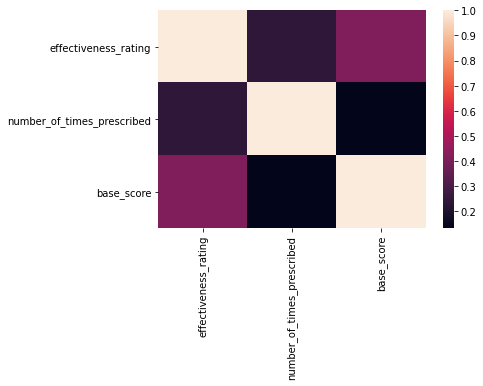

In [6]:
sns.heatmap(df.corr())

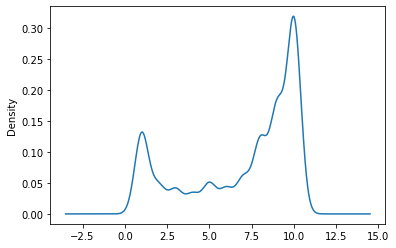

In [7]:
df.effectiveness_rating.plot.kde()

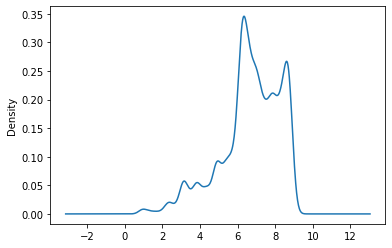

In [8]:
df.base_score.plot.kde()


 mu = 6.66 and sigma = 1.59



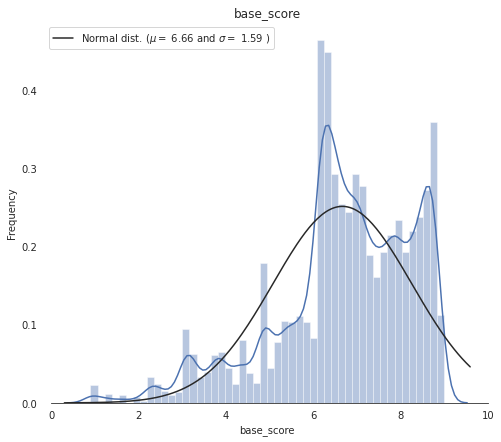

In [9]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df['base_score'], fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['base_score'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="base_score")
ax.set(title="base_score")
sns.despine(trim=True, left=True)

plt.show()

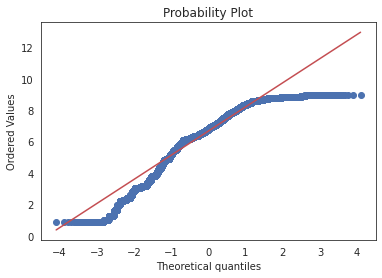

In [10]:
fig = plt.figure()
res = stats.probplot(df['base_score'], plot=plt)
plt.show()

Automatically created module for IPython interactive environment


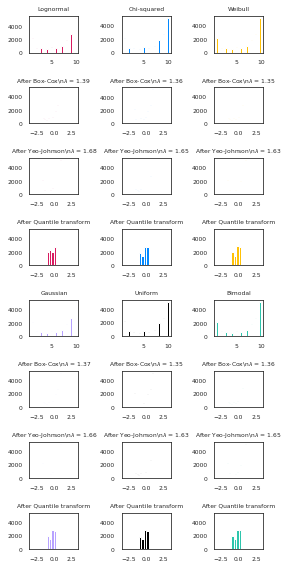

In [11]:
print(__doc__)


N_SAMPLES = 1000
FONT_SIZE = 6
BINS = 30


rng = np.random.RandomState(304)
bc = PowerTransformer(method='box-cox')
yj = PowerTransformer(method='yeo-johnson')
# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
size = (N_SAMPLES, 1)


# lognormal distribution
X_lognormal = rng.lognormal(size=size)

# chi-squared distribution
f = 3
X_chisq = rng.chisquare(df=f, size=size)

# weibull distribution
a = 50
X_weibull = rng.weibull(a=a, size=size)

# gaussian distribution
loc = 100
X_gaussian = rng.normal(loc=loc, size=size)

# uniform distribution
X_uniform = rng.uniform(low=0, high=1, size=size)

# bimodal distribution
loc_a, loc_b = 100, 105
X_a, X_b = rng.normal(loc=loc_a, size=size), rng.normal(loc=loc_b, size=size)
X_bimodal = np.concatenate([X_a, X_b], axis=0)


# create plots
distributions = [
    ('Lognormal', X_lognormal),
    ('Chi-squared', X_chisq),
    ('Weibull', X_weibull),
    ('Gaussian', X_gaussian),
    ('Uniform', X_uniform),
    ('Bimodal', X_bimodal)
]

colors = ['#D81B60', '#0188FF', '#FFC107',
          '#B7A2FF', '#000000', '#2EC5AC']

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=plt.figaspect(2))
axes = axes.flatten()
axes_idxs = [(0, 3, 6, 9), (1, 4, 7, 10), (2, 5, 8, 11), (12, 15, 18, 21),
             (13, 16, 19, 22), (14, 17, 20, 23)]
axes_list = [(axes[i], axes[j], axes[k], axes[l])
             for (i, j, k, l) in axes_idxs]


for distribution, color, axes in zip(distributions, colors, axes_list):
    name, X = distribution
    X = df.effectiveness_rating.values.reshape(-1,1)
    X_train, X_test = train_test_split(X, test_size=.5)

    # perform power transforms and quantile transform
    X_trans_bc = bc.fit(X_train).transform(X_test)
    lmbda_bc = round(bc.lambdas_[0], 2)
    X_trans_yj = yj.fit(X_train).transform(X_test)
    lmbda_yj = round(yj.lambdas_[0], 2)
    X_trans_qt = qt.fit(X_train).transform(X_test)

    ax_original, ax_bc, ax_yj, ax_qt = axes

    ax_original.hist(X_train, color=color, bins=BINS)
    ax_original.set_title(name, fontsize=FONT_SIZE)
    ax_original.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

    for ax, X_trans, meth_name, lmbda in zip(
            (ax_bc, ax_yj, ax_qt),
            (X_trans_bc, X_trans_yj, X_trans_qt),
            ('Box-Cox', 'Yeo-Johnson', 'Quantile transform'),
            (lmbda_bc, lmbda_yj, None)):
        ax.hist(X_trans, color=color, bins=BINS)
        title = 'After {}'.format(meth_name)
        if lmbda is not None:
            title += r'\n$\lambda$ = {}'.format(lmbda)
        ax.set_title(title, fontsize=FONT_SIZE)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
        ax.set_xlim([-3.5, 3.5])


plt.tight_layout()
plt.show()

this is done

 mu = -0.00 and sigma = 1.02



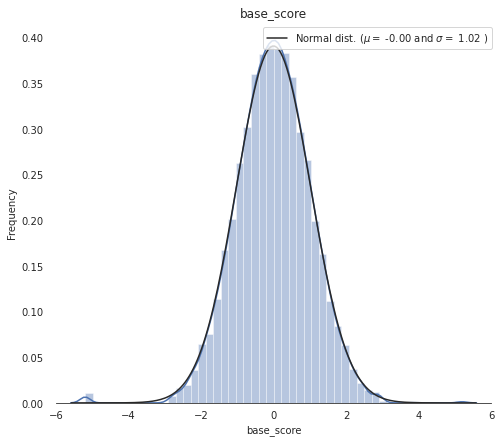

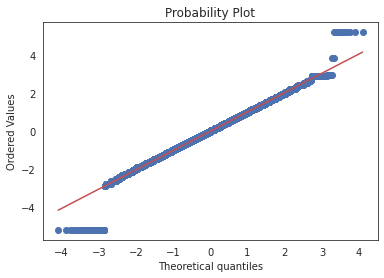


Chi-squared statistic = 1016.653, p = 0.000

The transformed data does not look Gaussian (reject the null hypothesis)


In [12]:
rng = np.random.RandomState(24546)
qt =  PowerTransformer()
X = df.base_score.values.reshape(-1,1)
#X = qt.fit_transform(X)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt.fit_transform(X)
print('this is done')
df['base_score'] = pd.Series(X.reshape(1,-1)[0])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(X, fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="base_score")
ax.set(title="base_score")
sns.despine(trim=True, left=True)
plt.show()

fig = plt.figure()
X = X.reshape(1,-1)[0]
res = stats.probplot(X, plot=plt)
plt.show()

k2, p = stats.normaltest(X)
print('\nChi-squared statistic = %.3f, p = %.3f' % (k2, p))

alpha = 0.05
if p > alpha:
    print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
else:
    print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')

this is done

 mu = 0.82 and sigma = 3.42



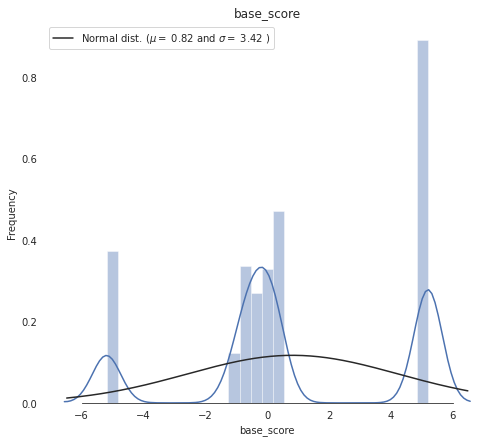

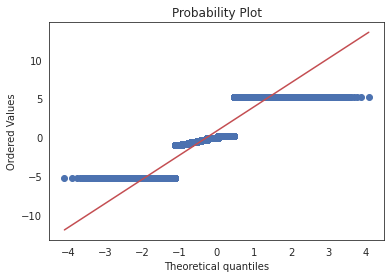


Chi-squared statistic = 3466.260, p = 0.000

The transformed data does not look Gaussian (reject the null hypothesis)


In [13]:
rng = np.random.RandomState(24546)
qt =  PowerTransformer()
X = df.effectiveness_rating.values.reshape(-1,1)
X = qt.fit_transform(X)
qt1 = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt1.fit_transform(X)
print('this is done')
df['effectiveness_rating'] = pd.Series(X.reshape(1,-1)[0])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(X, fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="base_score")
ax.set(title="base_score")
sns.despine(trim=True, left=True)
plt.show()

fig = plt.figure()
X = X.reshape(1,-1)[0]
res = stats.probplot(X, plot=plt)
plt.show()

k2, p = stats.normaltest(X)
print('\nChi-squared statistic = %.3f, p = %.3f' % (k2, p))

alpha = 0.05
if p > alpha:
    print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
else:
    print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')

this is done

 mu = -0.00 and sigma = 1.00



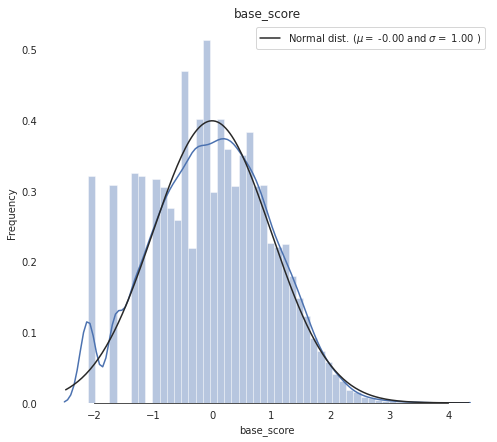

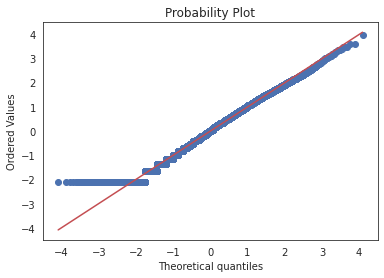


Chi-squared statistic = 304.562, p = 0.000

The transformed data does not look Gaussian (reject the null hypothesis)


In [14]:
rng = np.random.RandomState(24546)
qt =  PowerTransformer()
X = df.number_of_times_prescribed.values.reshape(-1,1)
#X = qt.fit_transform(X)
qt1 = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt.fit_transform(X)
print('this is done')
df['number_of_times_prescribed'] = pd.Series(X.reshape(1,-1)[0])
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(X, fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="base_score")
ax.set(title="base_score")
sns.despine(trim=True, left=True)
plt.show()

fig = plt.figure()
X = X.reshape(1,-1)[0]
res = stats.probplot(X, plot=plt)
plt.show()

k2, p = stats.normaltest(X)
print('\nChi-squared statistic = %.3f, p = %.3f' % (k2, p))

alpha = 0.05
if p > alpha:
    print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
else:
    print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')

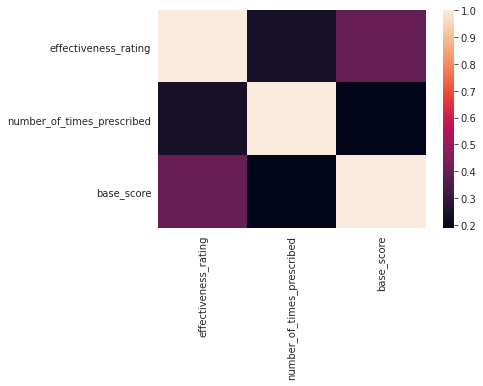

In [15]:
sns.heatmap(df.corr())

In [16]:
df

,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,number_of_times_prescribed,base_score
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",0.243504,0.451782,0.757254
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",-0.118323,2.360086,0.632244
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",-0.602120,0.063449,-0.366994
3,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",0.243504,0.730172,-0.127849
4,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",-1.013919,0.866803,-0.585413
...,...,...,...,...,...,...
32160,Cymbalta,Anxiety,"""I have been taking Cymbalta for 15 months now...",0.243504,1.562625,0.108212
32161,Nexplanon,Birth Control,"""I have had the Nexplanon since Dec. 27, 2016 ...",-0.474322,-2.101707,-5.199338
32162,Venlafaxine,Panic Disorde,"""Had panic attacks and social anxiety starting...",0.243504,0.385470,-0.460314
32163,Fluoxetine,Obsessive Compulsive Disorde,"""I have been off Prozac for about 4 weeks now....",-0.118323,0.276815,0.725118


In [17]:
df = pd.read_csv('/content/drive/My Drive/train.csv')
df = df.drop(columns=['drug_approved_by_UIC','patient_id'])
df1 = pd.read_csv('/content/drive/My Drive/test.csv')
df.head()

,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,number_of_times_prescribed,base_score
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,27,8.022969
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,192,7.858458
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,17,6.341969
3,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,37,6.590176
4,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,43,6.144782


In [18]:
rng = np.random.RandomState(24546)
qt =  PowerTransformer()
X = df.number_of_times_prescribed.values.reshape(-1,1)
#X = qt.fit_transform(X)
qt1 = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt.fit_transform(X)
print('this is done')
df['number_of_times_prescribed'] = pd.Series(X.reshape(1,-1)[0])
X = df1.number_of_times_prescribed.values.reshape(-1,1)
#X = qt.fit_transform(X)
qt1 = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt.fit_transform(X)
print('this is done')
df1['number_of_times_prescribed'] = pd.Series(X.reshape(1,-1)[0])

this is done
this is done


In [19]:
rng = np.random.RandomState(24546)
qt =  PowerTransformer()
X = df.effectiveness_rating.values.reshape(-1,1)
X = qt.fit_transform(X)
qt1 = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt1.fit_transform(X)
print('this is done')
df['effectiveness_rating'] = pd.Series(X.reshape(1,-1)[0])
X = df1.effectiveness_rating.values.reshape(-1,1)
X = qt.fit_transform(X)
qt1 = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt1.fit_transform(X)
print('this is done')
df1['effectiveness_rating'] = pd.Series(X.reshape(1,-1)[0])

this is done
this is done


In [20]:
rng = np.random.RandomState(24546)
qt =  PowerTransformer()
X = df.base_score.values.reshape(-1,1)
#X = qt.fit_transform(X)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
X = qt.fit_transform(X)
print('this is done')
df['base_score'] = pd.Series(X.reshape(1,-1)[0])

this is done


In [0]:
df1['base_score'] = -1
train = df[['name_of_drug', 'use_case_for_drug','effectiveness_rating','review_by_patient','number_of_times_prescribed','base_score']]
test = df1[['name_of_drug', 'use_case_for_drug','effectiveness_rating','review_by_patient','number_of_times_prescribed','base_score']]
data = pd.concat([train, test]).reset_index(drop=True)
features = [x for x in train.columns if x not in ['effectiveness_rating','number_of_times_prescribed','base_score','review_by_patient']]

out = []
for feat in features:
    lbl_enc = LabelEncoder()
    data[feat] = lbl_enc.fit_transform(data[feat].fillna(-1).astype(str).values)
    out.append(lbl_enc)
saved_embeddings_fname = "/content/drive/My Drive/labels.pickle"
with open(saved_embeddings_fname, 'wb') as f:
    pickle.dump(out, f, -1)
features = ['name_of_drug', 'use_case_for_drug']
train = data[data.base_score != -1].reset_index(drop=True)
test = data[data.base_score == -1].reset_index(drop=True)
test_data = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]
features = ['name_of_drug', 'use_case_for_drug']
train = data[data.base_score != -1].reset_index(drop=True)
test = data[data.base_score == -1].reset_index(drop=True)
test_data = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]

In [22]:
train

,name_of_drug,use_case_for_drug,effectiveness_rating,review_by_patient,number_of_times_prescribed,base_score
0,2222,351,0.243504,"""It has no side effect, I take it in combinati...",0.451782,0.757254
1,980,42,-0.118323,"""My son is halfway through his fourth week of ...",2.360086,0.632244
2,1285,114,-0.602120,"""I used to take another oral contraceptive, wh...",0.063449,-0.366994
3,352,432,0.243504,"""Suboxone has completely turned my life around...",0.730172,-0.127849
4,461,109,-1.013919,"""2nd day on 5mg started to work with rock hard...",0.866803,-0.585413
...,...,...,...,...,...,...
32160,562,79,0.243504,"""I have been taking Cymbalta for 15 months now...",1.562625,0.108212
32161,1495,114,-0.474322,"""I have had the Nexplanon since Dec. 27, 2016 ...",-2.101707,-5.199338
32162,2241,453,0.243504,"""Had panic attacks and social anxiety starting...",0.385470,-0.460314
32163,904,422,-0.118323,"""I have been off Prozac for about 4 weeks now....",0.276815,0.725118


In [23]:
# remove space
spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']
def remove_space(text):
    """
    remove extra spaces and ending space if any
    """
    for space in spaces:
        text = text.replace(space, ' ')
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text

# replace strange punctuations and raplace diacritics
from unicodedata import category, name, normalize

def remove_diacritics(s):
    return ''.join(c for c in normalize('NFKD', s.replace('ø', 'o').replace('Ø', 'O').replace('⁻', '-').replace('₋', '-'))
                  if category(c) != 'Mn')

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}
def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
    text = remove_diacritics(text)
    return text

# clean numbers
def clean_number(text):
    if bool(re.search(r'\d', text)):
        text = re.sub(r'(\d+)([a-zA-Z])', '\g<1> \g<2>', text) # digits followed by a single alphabet...
        text = re.sub(r'(\d+) (th|st|nd|rd) ', '\g<1>\g<2> ', text) #1st, 2nd, 3rd, 4th...
        text = re.sub(r'(\d+),(\d+)', '\g<1>\g<2>', text)
    return text

import string
regular_punct = list(string.punctuation)
extra_punct = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤',
    ':)', ': )', ':-)', '(:', '( :', '(-:', ':\')',
    ':D', ': D', ':-D', 'xD', 'x-D', 'XD', 'X-D',
    '<3', ':*',
    ';-)', ';)', ';-D', ';D', '(;',  '(-;',
    ':-(', ': (', ':(', '\'):', ')-:',
    '-- :','(', ':\'(', ':"(\'',]

def handle_emojis(text): #Speed can be improved via a simple if check :)
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    return text

def stop(text):
    
    from nltk.corpus import stopwords
    
    text = " ".join([w.lower() for w in text.split()])
    stop_words = stopwords.words('english')
    
    words = [w for w in text.split() if not w in stop_words]
    return " ".join(words)

all_punct = list(set(regular_punct + extra_punct))
# do not spacing - and .
all_punct.remove('-')
all_punct.remove('.')

# clean repeated letters
def clean_repeat_words(text):
    
    text = re.sub(r"(I|i)(I|i)+ng", "ing", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+y", "lly", text)
    text = re.sub(r"(A|a)(A|a)(A|a)+", "a", text)
    text = re.sub(r"(C|c)(C|c)(C|c)+", "cc", text)
    text = re.sub(r"(D|d)(D|d)(D|d)+", "dd", text)
    text = re.sub(r"(E|e)(E|e)(E|e)+", "ee", text)
    text = re.sub(r"(F|f)(F|f)(F|f)+", "ff", text)
    text = re.sub(r"(G|g)(G|g)(G|g)+", "gg", text)
    text = re.sub(r"(I|i)(I|i)(I|i)+", "i", text)
    text = re.sub(r"(K|k)(K|k)(K|k)+", "k", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+", "ll", text)
    text = re.sub(r"(M|m)(M|m)(M|m)+", "mm", text)
    text = re.sub(r"(N|n)(N|n)(N|n)+", "nn", text)
    text = re.sub(r"(O|o)(O|o)(O|o)+", "oo", text)
    text = re.sub(r"(P|p)(P|p)(P|p)+", "pp", text)
    text = re.sub(r"(Q|q)(Q|q)+", "q", text)
    text = re.sub(r"(R|r)(R|r)(R|r)+", "rr", text)
    text = re.sub(r"(S|s)(S|s)(S|s)+", "ss", text)
    text = re.sub(r"(T|t)(T|t)(T|t)+", "tt", text)
    text = re.sub(r"(V|v)(V|v)+", "v", text)
    text = re.sub(r"(Y|y)(Y|y)(Y|y)+", "y", text)
    text = re.sub(r"plzz+", "please", text)
    text = re.sub(r"(Z|z)(Z|z)(Z|z)+", "zz", text)
    text = re.sub(r"(-+|\.+)", " ", text) #new haha #this adds a space token so we need to remove xtra spaces
    return text

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def preprocess(text):
    """
    preprocess text main steps
    """
    text = remove_space(text)
    text = clean_special_punctuations(text)
    text = handle_emojis(text)
    text = clean_number(text)
    text = spacing_punctuation(text)
    text = clean_repeat_words(text)
    text = remove_space(text)
    #text = stop(text)# if changing this, then chnage the dims 
    #(not to be done yet as its effecting the embeddings..,we might be
    #loosing words)...
    return text

mispell_dict = {'😉':'wink','😂':'joy','😀':'stuck out tongue', 'theguardian':'the guardian','deplorables':'deplorable', 'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine','fentayal': 'fentanyl','designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers','negotiatiations': 'negotiations','dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments','envirnmetalists': 'environmentalists',}
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def correct_contraction(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_seed(2411)
SEED = 42
num_partitions = 10  # number of partitions to split dataframe
num_cores = psutil.cpu_count()  # number of cores on your machine

print('number of cores:', num_cores)

def df_parallelize_run(df, func):
    
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    
    return df

number of cores: 2


In [24]:
from tqdm import tqdm
tqdm.pandas()

def text_clean_wrapper(df):
    
    df["review_by_patient"] = df["review_by_patient"].astype('str').transform(preprocess)
    df['review_by_patient'] = df['review_by_patient'].transform(lambda x: correct_spelling(x, mispell_dict))
    df['review_by_patient'] = df['review_by_patient'].transform(lambda x: correct_contraction(x, contraction_mapping))
    
    return df

#fast!
train = df_parallelize_run(train, text_clean_wrapper)
test  = df_parallelize_run(test, text_clean_wrapper)

import gc
gc.enable()
del mispell_dict, all_punct, special_punc_mappings, regular_punct, extra_punct
gc.collect()

0

In [0]:
def run_seq(train, test):
    '''
        credits go to: https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution/ 
    '''
    
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(list(train['review_by_patient']) + list(test['review_by_patient']))
    word_index = tokenizer.word_index
    X_train = tokenizer.texts_to_sequences(list(train['review_by_patient']))
    X_test = tokenizer.texts_to_sequences(list(test['review_by_patient']))
    X_train = pad_sequences(X_train,maxlen = 180)
    X_test = pad_sequences(X_test, maxlen = 180)
    
    return X_train, X_test, word_index

In [0]:
EMB_PATHS = [
    'crawl-300d-2M.vec',
    'glove.840B.300d.txt'
]

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

def build_embedding_matrix(word_index, path):
    '''
     credits to: https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold
    '''
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
            
    del embedding_index
    gc.collect()
    return embedding_matrix

def build_embeddings(word_index):
    '''
     credits to: https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold
     credits go to: https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution/ 
    '''
    embedding_matrix = np.concatenate(
        [build_embedding_matrix(word_index, f) for f in EMB_PATHS], axis=-1) 
    return embedding_matrix

In [0]:
embedding_matrix = build_embeddings(word_index)

In [0]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [0]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='kernel',
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='kernel',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


        
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
def create_model(data, catcols):    
    inputs = []
    outputs = []

    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = 180
        inp = Input(shape=(1,))
        out = Embedding(num_unique_values, embed_dim, name=c)(inp)
        out = SpatialDropout1D(0.3)(out)
        out = Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)

    inp1 = Input(shape=(180,))

    x = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp1)
    x = SpatialDropout1D(.3)(x)
    
    x1 = Bidirectional(LSTM(180, return_sequences=True))(x)
    x1 = Dropout(0.3)(x1)
    x2 = Bidirectional(GRU(180, return_sequences=True))(x1)
    x2 = Dropout(0.3)(x2)
    att1 = Attention(180)(x1)
    att2 = Attention(180)(x2)
    x3 = Average()([att1,att2])
    max_pool1 = GlobalAveragePooling1D()(x1)
    max_pool2 = GlobalAveragePooling1D()(x2)

    inp2 = Input(shape=(2,))
    x = Dense(2, activation="elu")(inp2)
    outputs.append(x)
    outputs.append(x3)
    outputs.append(max_pool1)
    outputs.append(max_pool2)
    x = Concatenate()(outputs)
    x = BatchNormalization()(x)
    
    x = Dense(700, activation="elu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(300, activation="elu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(30, activation="elu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    y = Dense(1, activation="sigmoid")(x)
    print(inputs[0].shape,)
    model = Model(inputs=[inputs[0],inputs[1],inp1,inp2], outputs=y)
    return model

In [0]:
text_train, text_test, word_index = run_seq(train,test)

In [0]:
text_train = pd.DataFrame(text_train)
text_test = pd.DataFrame(text_test)

In [0]:

oof_preds = np.zeros((len(train)))
test_preds = np.zeros((len(test)))
fold = 0
file_path = "best_model.hdf5"
skf = KFold(n_splits=10)
for train_index, test_index in skf.split(train, train.base_score.values):
    print('fold',fold)
    X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
    text_trs, text_tts = text_train.iloc[train_index, :] , text_train.iloc[test_index, :]
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train, y_test = X_train.base_score.values, X_test.base_score.values
    X_t = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
    X_tt =  [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    es = callbacks.EarlyStopping(monitor='mae', min_delta=0.001, patience=3,
                                 verbose=1, mode='min', baseline=None, restore_best_weights=True)

    rlr = callbacks.ReduceLROnPlateau(monitor='mae', factor=0.5,
                                      patience=3, min_lr=1e-7, mode='min', verbose=1)
    
    check_point = ModelCheckpoint(str(fold)+'_'+file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    
    x_t = text_trs
    x_tt = text_tts
    x_T = X_train[['effectiveness_rating','number_of_times_prescribed']].values
    x_TT = X_test[['effectiveness_rating','number_of_times_prescribed']].values

    model = create_model(data, features)
    model.compile(loss=rmse, optimizer='adam')
    model.fit([X_t[0],X_t[1],x_t,x_T],
              y_train,
              validation_data = ([X_tt[0],X_tt[1],x_tt,x_TT],y_test),
              verbose=1,
              batch_size=1024,
              callbacks=[es,rlr,check_point],
              epochs=30
             )
    valid_fold_preds = model.predict([X_tt[0],X_tt[1],x_tt,x_TT])
    test_fold_preds = model.predict([test_data[0],test_data[1],text_test,
                        test[['effectiveness_rating','number_of_times_prescribed']].values])
    oof_preds[test_index] = valid_fold_preds.ravel()
    test_preds += test_fold_preds.ravel()
    fold = fold + 1
    K.clear_session()

fold 0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28948 samples, validate on 3217 samples
Epoch 1/30
28948/28948 [==============================] - 41s 1ms/step - loss: 0.8892 - val_loss: 0.8290

Epoch 00001: val_loss improved from inf to 0.82902, saving model to 0_best_model.hdf5


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `mae` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `mae` which is not available. Available metrics are: val_loss,loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/30
28948/28948 [==============================] - 38s 1ms/step - loss: 0.8399 - val_loss: 0.7975

Epoch 00002: val_loss improved from 0.82902 to 0.79754, saving model to 0_best_model.hdf5
Epoch 3/30
28948/28948 [==============================] - 39s 1ms/step - loss: 0.8205 - val_loss: 0.7876

Epoch 00003: val_loss improved from 0.79754 to 0.78757, saving model to 0_best_model.hdf5
Epoch 4/30
28948/28948 [==============================] - 38s 1ms/step - loss: 0.8031 - val_loss: 0.8080

Epoch 00004: val_loss did not improve from 0.78757
Epoch 5/30
28948/28948 [==============================] - 38s 1ms/step - loss: 0.7896 - val_loss: 0.8137

Epoch 00005: val_loss did not improve from 0.78757
Epoch 6/30
28948/28948 [==============================] - 38s 1ms/step - loss: 0.7810 - val_loss: 0.7863

Epoch 00006: val_loss improved from 0.78757 to 0.78635, saving model to 0_best_model.hdf5
Epoch 7/30
28948/28948 [==============================] - 38s 1ms/step - loss: 0.7718 - val_loss: 

In [0]:
use_case_for_drug = model.get_layer('use_case_for_drug').get_weights()[0]
name_of_drug = model.get_layer('name_of_drug').get_weights()[0]
len(data.use_case_for_drug.unique())
saved_embeddings_fname = "/content/drive/My Drive/embeddings.pickle"
with open(saved_embeddings_fname, 'wb') as f:
    pickle.dump([use_case_for_drug,name_of_drug], f, -1)
test_preds = test_preds/10
test_preds = qt.inverse_transform(test_preds.reshape(-1,1))
sub = pd.read_csv('/content/drive/My Drive/test.csv')
sub['base_score'] = pd.Series(test_preds.ravel())
sub[['patient_id','base_score']].to_csv('stdai1.csv',index=False)